In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
#%matplotlib notebook
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm_refpoints = ps.StanModel(file="nn_refpoints_normalizedX.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e0ad5ec06ab076c3a7530c5bbfd4624e NOW.


In [3]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
X = X[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))
Nobs = np.shape(X)[1]

### Local linear embedding for reference points:

In [4]:
n_ref = 100
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
Y_embedded = embedding.fit_transform(Y.transpose()).transpose()

In [8]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = Y_embedded[:,ref_points]
Y_train = Y[:,train]

In [9]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=np.shape(X)[0], 
                      out_dim=np.shape(Y)[0], 
                      hidden_dim=50,
                      n_ref=np.shape(Y_ref)[1],
                      y=Y_train, 
                      y_ref=Y_ref,
                      X_ref=X_ref)

#### Run Stan:

In [11]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints_lle = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=8,chains=8,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints_lle);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


30.5 minutes to run
Inference for Stan model: anon_model_e0ad5ec06ab076c3a7530c5bbfd4624e.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]                        0.07    0.09    0.7  -1.33  -0.39   0.09   0.54   1.38     56   1.07
X[2,1]                        0.09    0.07   0.63  -1.16  -0.35   0.09    0.5   1.35     84   1.04
X[3,1]                        0.11    0.04   0.65  -1.21  -0.32   0.13   0.53   1.43    236   1.03
X[4,1]                       -0.09    0.07   0.63  -1.37  -0.53   -0.1   0.34   1.15     83   1.04
X[5,1]                         0.1    0.07   0.63  -1.13  -0.34   0.09   0.53   1.33     91   1.03
X[6,1]                       -0.03    0.01    0.6   -1.2  -0.44  -0.04   0.37   1.18   2530   1.01
X[7,1]                       -0.07    0.07   0.76  -1.52  -0.58  -0.08   0.44   1.46    110   1.06
X

#### Look at results:

In [20]:
trace_lle = fit_refpoints_lle.extract()
n_samples = np.shape(trace_lle['X'])[0]
n_latent = np.shape(trace_lle['X'])[1]

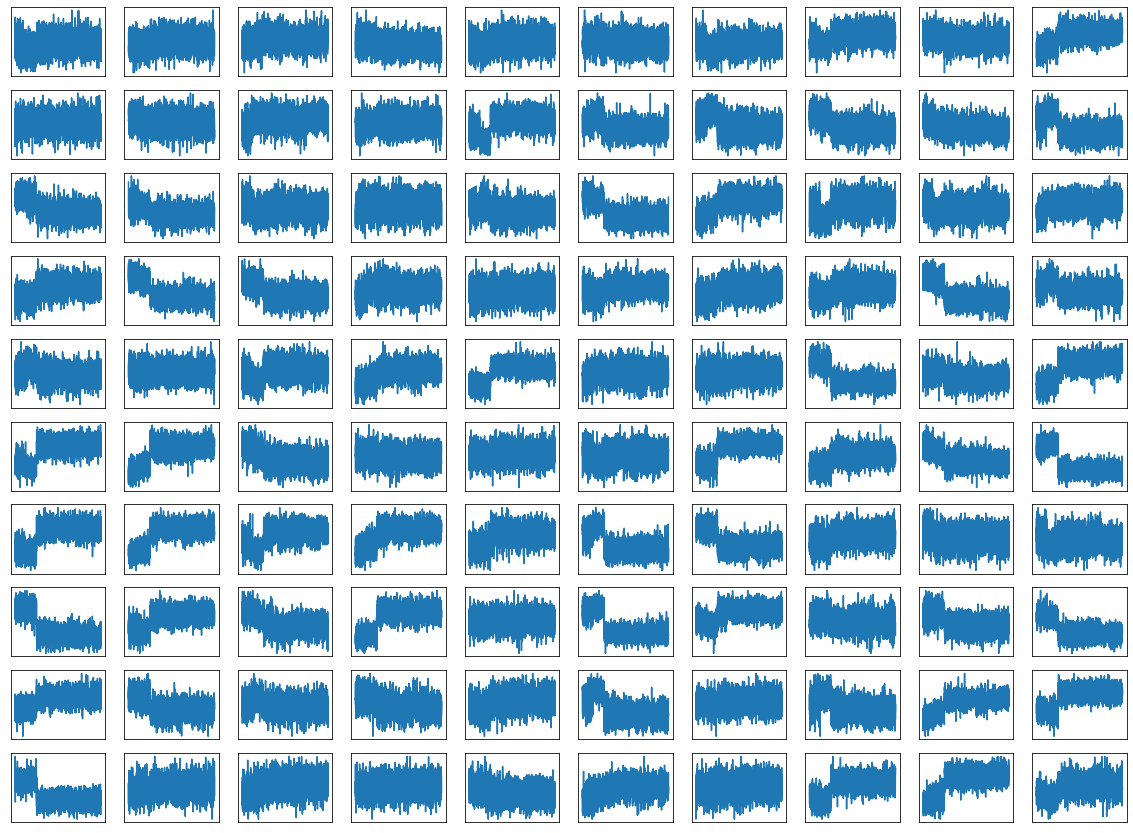

In [33]:
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace_lle['X'][:,k,0])
        plt.xticks([])
        plt.yticks([])
plt.show()

In [22]:
def L2_loss(Y, X, weights_1, bias_1, weights_2, bias_2) :
    Y_pred = np.matmul(np.tanh(np.matmul(X,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((Y-Y_pred)**2,axis=1))

In [23]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y_train.transpose(), trace_lle['X'][i], trace_lle['weights_1'][i], 
                      trace_lle['bias_1'][i], trace_lle['weights_2'][i], trace_lle['bias_2'][i]) \
#                 / trace_lle['error_sigma2'][i]

100%|██████████| 4000/4000 [00:01<00:00, 2105.94it/s]


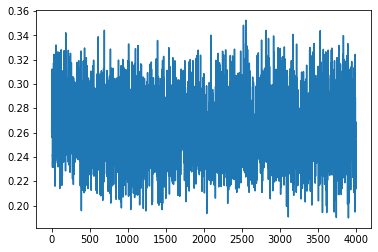

In [24]:
plt.plot(loss)

In [25]:
in_dim = np.shape(X_ref)[0]
hidden_dim = np.shape(trace_lle['weights_1'])[-1]

AX = np.zeros((n_samples,hidden_dim,Nobs-n_ref))
for i in range(n_samples) :
    AX[i,:] = np.matmul(trace_lle['weights_1'][i].transpose(), trace_lle['X'][i].transpose())

In [29]:
pw_dist_matrix_lle = np.zeros((n_latent,n_latent,n_samples))
for i in range(10) :
    for j in range(10) :
        for k in range(n_samples) :
            pw_dist_matrix_lle[i,j,k] = np.linalg.norm(trace_lle['X'][k,i]-
                                                       trace_lle['X'][k,j])

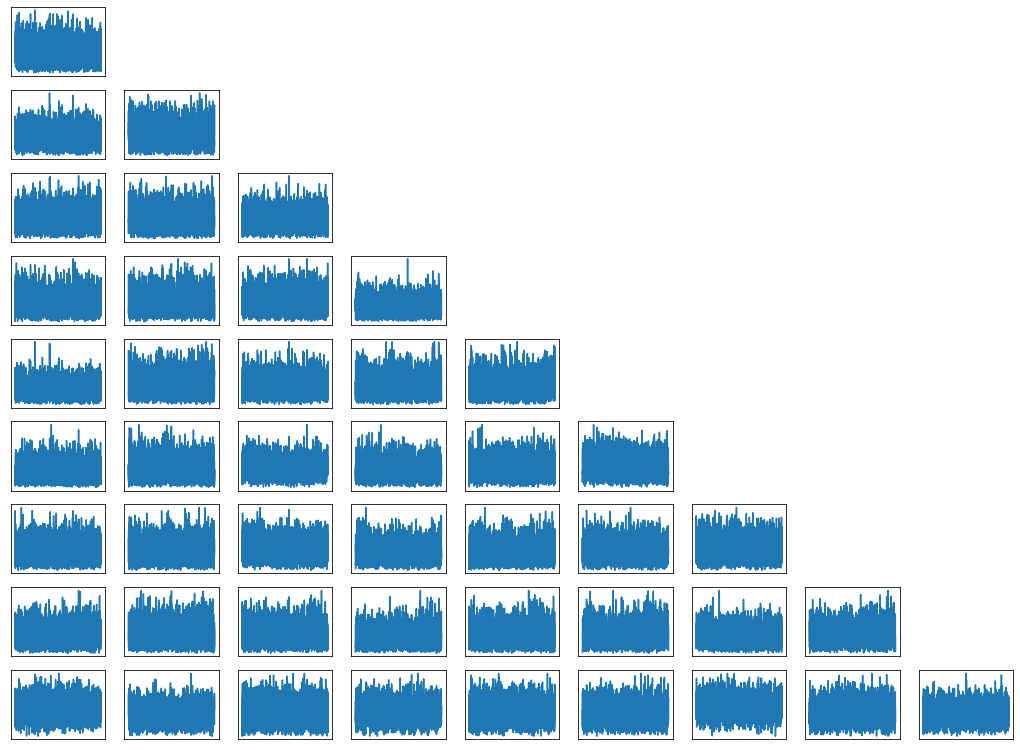

In [30]:
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            plt.subplot(10,10,10*i+j+1)
            plt.plot(pw_dist_matrix_lle[i,j])
            plt.xticks([])
            plt.yticks([])
plt.show()